In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.dataloader import DataLoader, get_radiomap_from_rpmap
from src.constants import constants
from src.preprocess import interpolacion_pixel_proximo

get_loader = DataLoader(data_dir=f"{constants.data.train.FINAL_PATH}/groundtruth.csv",
                        aps_list=constants.aps, batch_size=30, step_size=5,
                        size_reference_point_map=28, return_axis_coords=True)

X, y, [x_coords, y_coords] = get_loader()

rpmap, rpmap_labels = X[:,:,:,0], y[:,0]

Interpolando datos con píxel más próximo si son coincidentes


23it [00:36,  1.58s/it]


# Obtener radiomap desde el RPMAP

Objetivo:

Transformar X en datos tabulares estilo radiomap:


(223x28x28=174832 filas, 7 columnas wifi + 2 columnas coordenadas)

In [115]:
radiomap_extended = get_radiomap_from_rpmap(rpmap, x_coords, y_coords)

# Obtenemos el radiomap convencional (sin mallado continuo)

In [116]:
radiomap = pd.read_csv(f"{constants.data.train.FINAL_PATH}/groundtruth.csv")
radiomap = interpolacion_pixel_proximo(radiomap, threshold=30)
Xtrain, ytrain = radiomap[constants.aps].to_numpy(), radiomap[["Longitude", "Latitude"]].to_numpy()

23it [00:35,  1.55s/it]


# Obtenemos el radiomap extendido (con mallado continuo)

In [117]:
Xtrain_RPMAP, ytrain_RPMAP = radiomap_extended[constants.aps].to_numpy(), radiomap_extended[["Longitude", "Latitude"]].to_numpy()

# Obtenemos el radiomap extendido e incrementado con data augmentation

In [118]:
# cargamos cGAN
import tensorflow as tf
generator = tf.keras.models.load_model(f"{constants.outputs.models.cgan_28}/checkpoints/c_gan499.h5")

class DataAugmentation:
    def __init__(self, path_to_generator):
        self.generator = self.get_model(path_to_generator)

    @staticmethod
    def get_model(path_to_generator):
        return tf.keras.models.load_model(path_to_generator)

    @staticmethod
    def reescale_output(output):
        maximum, minimum = np.max(output), np.min(output)
        return (output - minimum) / (maximum - minimum)


    def __call__(self, n_samples_per_label: int = 223):
        n_classes = len(constants.aps)
        noise_input = np.random.normal(0, 1, size=[n_samples_per_label*n_classes, 100])
        input_labels = np.repeat(np.arange(0, n_classes), n_samples_per_label).reshape(-1, 1)
        generated = self.generator.predict([noise_input, input_labels])[:,:,:,0]
        generated = self.reescale_output(generated)
        return generated, input_labels


data_augmentation = DataAugmentation(path_to_generator=f"{constants.outputs.models.cgan_28}/checkpoints/c_gan499.h5")
generated, input_labels = data_augmentation(n_samples_per_label=30)



7/7 [==============================] - 0s 33ms/step


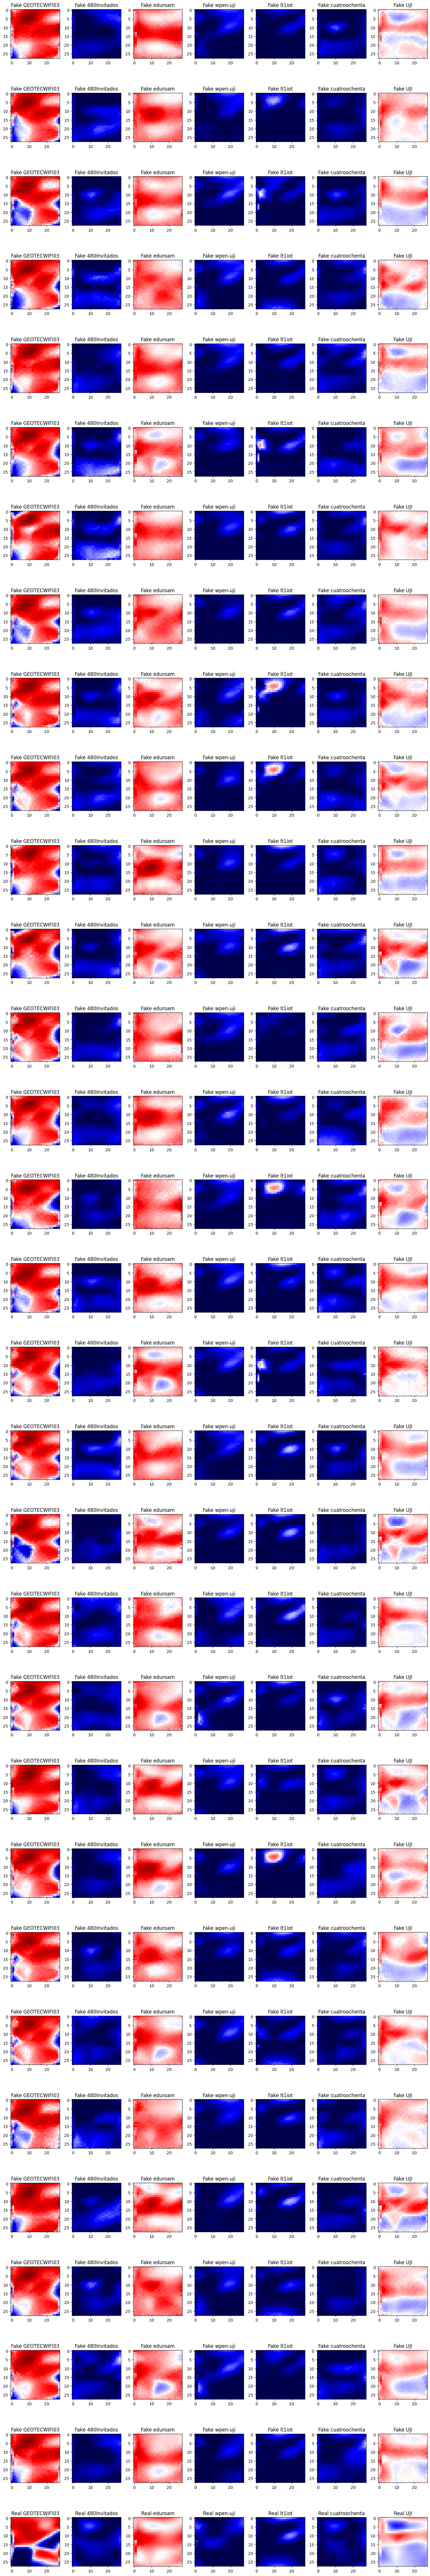

In [119]:
# plot de las imagenes reales vs las generadas donde cada columna corresponde con un label y la primera fila corresponde con el valor real
def plot2_reals_vs_fakes(imagenes_reales, imagenes_generadas, save_ok=True, path_out: str=None):

    # plot en la primera fila de una imagen real por cada label
    samples_per_ap = int(imagenes_reales.shape[0]/len(constants.aps))
    n_predicted = int(imagenes_generadas.shape[0]/len(constants.aps))
    plt.figure(figsize=(len(constants.aps)*2+1, 3*n_predicted))
    for n_ap, ap in enumerate(constants.aps):
        for x in range(n_predicted):
            plt.subplot(n_predicted+1, len(constants.aps), n_ap+len(constants.aps)*x+1)
            plt.imshow(imagenes_generadas[n_ap*n_predicted+x,:,:], cmap="seismic", vmin=0, vmax=1)
            plt.title(f"Fake {ap}")

    for n_ap, ap in enumerate(constants.aps):
        idx_ap = samples_per_ap*n_ap
        plt.subplot(n_predicted+1, len(constants.aps), n_predicted*len(constants.aps)+n_ap+1)
        plt.imshow(imagenes_reales[idx_ap,:,:], cmap="seismic", vmin=0, vmax=1)
        plt.title(f"Real {ap}")
    plt.tight_layout()
    if save_ok:
        if path_out is None:
            plt.savefig("reals_vs_fakes.png")
        else:
            plt.savefig(f"{path_out}/reals_vs_fakes.png")
    plt.show()


plot2_reals_vs_fakes(rpmap, generated, save_ok=True)


In [120]:
samples_per_ap = int(rpmap.shape[0]/len(constants.aps))
samples_generated_per_ap = int(generated.shape[0]/len(constants.aps))
rpmap_ext = np.zeros((rpmap.shape[0]+samples_generated_per_ap*len(constants.aps), rpmap.shape[1], rpmap.shape[2]))
count_gen = 0
for n_ap, ap in enumerate(constants.aps):
    for batch_temporal in range(samples_per_ap):
        id_row = n_ap*samples_per_ap+batch_temporal
        rpmap_ext[count_gen,:,:] = rpmap[id_row,:,:]
        count_gen+=1
    for id_gen in range(samples_generated_per_ap):
        rpmap_ext[count_gen,:,:] = generated[id_gen+samples_generated_per_ap*n_ap]
        count_gen+=1

radiomap_generated = get_radiomap_from_rpmap(rpmap_ext, x_coords, y_coords)

In [123]:
Xtrain_generated, ytrain_generated = radiomap_generated[constants.aps].to_numpy(), radiomap_generated[["Longitude", "Latitude"]].to_numpy()

# TODOS LOS DATOS SINTÉTICOS (SIN DATA AUGMENTATION)

In [133]:
data_augmentation = DataAugmentation(path_to_generator=f"{constants.outputs.models.cgan_28}/checkpoints/c_gan499.h5")
generated, input_labels = data_augmentation(n_samples_per_label=300)
radiomap_synthetic = get_radiomap_from_rpmap(generated, x_coords, y_coords)
Xtrain_synthetic, ytrain_synthetic = radiomap_synthetic[constants.aps].to_numpy(), radiomap_synthetic[["Longitude", "Latitude"]].to_numpy()

66/66 [==============================] - 1s 7ms/step


# Leemos e interpolamos los datos ausentes de test

In [122]:
test = pd.read_csv(f"{constants.data.test.FINAL_PATH}/groundtruth.csv")
test_interpolated = interpolacion_pixel_proximo(test, threshold=30)
Xtest, ytest = test_interpolated[constants.aps].to_numpy(), test_interpolated[["Longitude", "Latitude"]].to_numpy()

17it [00:00, 24.17it/s]


# Entrenamiento y estimación de coordenadas con Test

In [135]:
import sklearn as sk
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import multiprocessing

# Con radiomap
knn = KNeighborsRegressor(n_neighbors=3, n_jobs=multiprocessing.cpu_count()-1).fit(Xtrain, ytrain)
rf = RandomForestRegressor(n_estimators=500, n_jobs=multiprocessing.cpu_count()-1).fit(Xtrain, ytrain)


# Con radiomap aumentado con mallado continuo
knn_RPMAP = KNeighborsRegressor(n_neighbors=3, n_jobs=multiprocessing.cpu_count()-1).fit(Xtrain_RPMAP, ytrain_RPMAP)
rf_RPMAP = RandomForestRegressor(n_estimators=500, n_jobs=multiprocessing.cpu_count()-1).fit(Xtrain_RPMAP, ytrain_RPMAP)


# Aumentados (+23520 filas) con GAN
knn_generated = KNeighborsRegressor(n_neighbors=3, n_jobs=multiprocessing.cpu_count()-1).fit(Xtrain_generated, ytrain_generated)
rf_generated = RandomForestRegressor(n_estimators=500, n_jobs=multiprocessing.cpu_count()-1).fit(Xtrain_generated, ytrain_generated)

# COMPLETAMENTE SINTÉTICOS con GAN
knn_synthetic = KNeighborsRegressor(n_neighbors=3, n_jobs=multiprocessing.cpu_count()-1).fit(Xtrain_synthetic, ytrain_synthetic)
rf_synthetic = RandomForestRegressor(n_estimators=500, n_jobs=multiprocessing.cpu_count()-1).fit(Xtrain_synthetic, ytrain_synthetic)

ypred_knn = knn.predict(Xtest)
ypred_rf = rf.predict(Xtest)

ypred_knn_RPMAP = knn_RPMAP.predict(Xtest)
ypred_rf_RPMAP = rf_RPMAP.predict(Xtest)

ypred_knn_generated = knn_generated.predict(Xtest)
ypred_rf_generated = rf_generated.predict(Xtest)

ypred_knn_synthetic = knn_synthetic.predict(Xtest)
ypred_rf_synthetic = rf_synthetic.predict(Xtest)

euclidean_distances_knn = np.sqrt(np.sum((ypred_knn - ytest) ** 2, axis=1))
euclidean_distances_rf = np.sqrt(np.sum((ypred_rf - ytest) ** 2, axis=1))

euclidean_distances_knn_RPMAP = np.sqrt(np.sum((ypred_knn_RPMAP - ytest) ** 2, axis=1))
euclidean_distances_rf_RPMAP = np.sqrt(np.sum((ypred_rf_RPMAP - ytest) ** 2, axis=1))

euclidean_distances_knn_generated = np.sqrt(np.sum((ypred_knn_generated - ytest) ** 2, axis=1))
euclidean_distances_rf_generated = np.sqrt(np.sum((ypred_rf_generated - ytest) ** 2, axis=1))

euclidean_distances_knn_synthetic = np.sqrt(np.sum((ypred_knn_synthetic - ytest) ** 2, axis=1))
euclidean_distances_rf_synthetic = np.sqrt(np.sum((ypred_rf_synthetic - ytest) ** 2, axis=1))

sorted_knn = np.sort(euclidean_distances_knn)
sorted_rf = np.sort(euclidean_distances_rf)

sorted_knn_RPMAP = np.sort(euclidean_distances_knn_RPMAP)
sorted_rf_RPMAP = np.sort(euclidean_distances_rf_RPMAP)

sorted_knn_generated = np.sort(euclidean_distances_knn_generated)
sorted_rf_generated = np.sort(euclidean_distances_rf_generated)

sorted_knn_synthetic = np.sort(euclidean_distances_knn_synthetic)
sorted_rf_synthetic = np.sort(euclidean_distances_rf_synthetic)


In [136]:
print(f">> KNN --- mean: {np.mean(sorted_knn):.2f}, 75% perc: {np.percentile(sorted_knn, 75):.2f}")
print(f">> RF --- mean: {np.mean(sorted_rf):.2f}, 75% perc: {np.percentile(sorted_rf, 75):.2f}")
print(f">> KNN RPMAP --- mean: {np.mean(sorted_knn_RPMAP):.2f}, 75% perc: {np.percentile(sorted_knn_RPMAP, 75):.2f}")
print(f">> RF RPMAP --- mean: {np.mean(sorted_rf_RPMAP):.2f}, 75% perc: {np.percentile(sorted_rf_RPMAP, 75):.2f}")
print(f">> KNN GAN --- mean: {np.mean(sorted_knn_generated):.2f}, 75% perc: {np.percentile(sorted_knn_generated, 75):.2f}")
print(f">> RF GAN --- mean: {np.mean(sorted_rf_generated):.2f}, 75% perc: {np.percentile(sorted_rf_generated, 75):.2f}")
print(f">> KNN SYNTHETIC --- mean: {np.mean(sorted_knn_synthetic):.2f}, 75% perc: {np.percentile(sorted_knn_synthetic, 75):.2f}")
print(f">> RF SYNTHETIC --- mean: {np.mean(sorted_rf_synthetic):.2f}, 75% perc: {np.percentile(sorted_rf_synthetic, 75):.2f}")

>> KNN --- mean: 5.58, 75% perc: 6.84
>> RF --- mean: 4.89, 75% perc: 7.58
>> KNN RPMAP --- mean: 4.41, 75% perc: 6.35
>> RF RPMAP --- mean: 4.68, 75% perc: 6.50
>> KNN GAN --- mean: 5.00, 75% perc: 7.21
>> RF GAN --- mean: 4.79, 75% perc: 6.76
>> KNN SYNTHETIC --- mean: 6.19, 75% perc: 8.34
>> RF SYNTHETIC --- mean: 5.63, 75% perc: 6.91


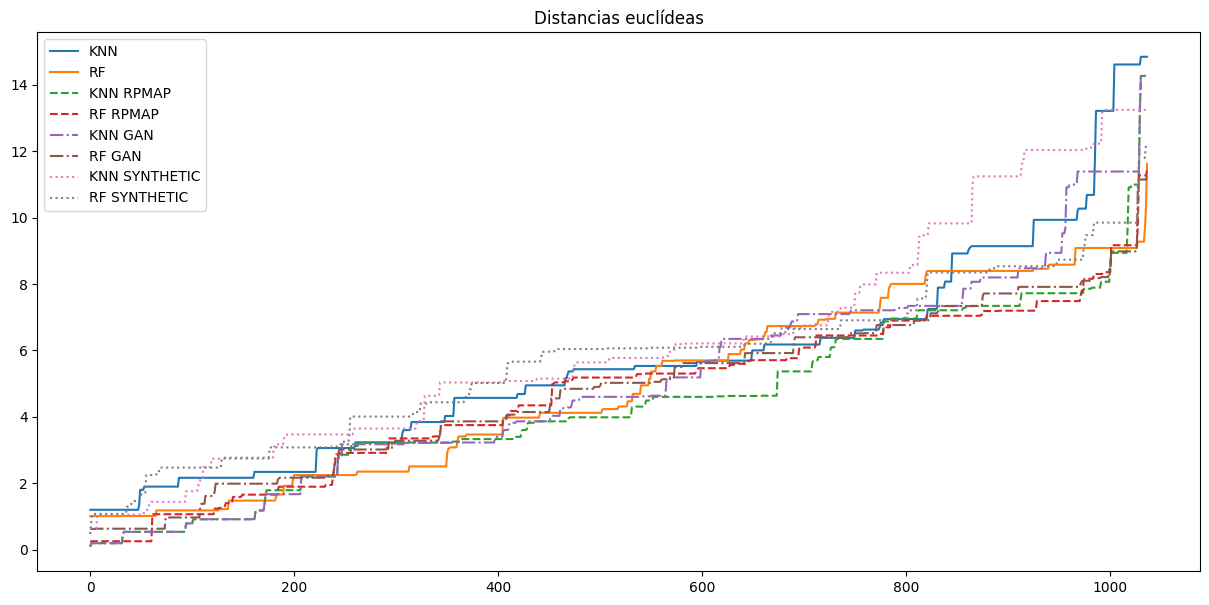

In [137]:


plt.figure(figsize=(15, 7))
plt.plot(sorted_knn, label="KNN")
plt.plot(sorted_rf, label="RF")
plt.plot(sorted_knn_RPMAP, linestyle="--", label="KNN RPMAP")
plt.plot(sorted_rf_RPMAP, linestyle="--", label="RF RPMAP")
plt.plot(sorted_knn_generated, linestyle="-.", label="KNN GAN")
plt.plot(sorted_rf_generated, linestyle="-.", label="RF GAN")
plt.plot(sorted_knn_synthetic, linestyle=":", label="KNN SYNTHETIC")
plt.plot(sorted_rf_synthetic, linestyle=":", label="RF SYNTHETIC")
plt.title("Distancias euclídeas")
plt.legend()
plt.show()

